In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Recreation of ProPublica's Compas data in Python

## Load data and recreate filters from ProPublica

In [2]:
# Build csv_path as "absolute path" in order to call this method from anywhere.
# Use os.path.abspath('') instead as an absolute path anchor independant of file location
# Use os.path library to construct path independent of Mac vs. Unix vs. Windows specificities
root_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
csv_path = os.path.join(root_dir, "data-ProPublica","compas-scores-two-years.csv")


In [3]:
# Load data and transform date columsn to "datetime"
raw_data = pd.read_csv(csv_path, parse_dates=["c_jail_in", "c_jail_out"])
#raw_data = pd.read_csv("../../data-ProPublica/compas-scores-two-years.csv", parse_dates=["c_jail_in", "c_jail_out"])
raw_data.shape

(7214, 53)

ProPublicas reasoning for filter `raw_data`:
>However not all of the rows are useable for the first round of analysis.
>There are a number of reasons remove rows because of missing data:
>* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
>* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
>* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
>* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.*

In [51]:
# Select columns of interest and store as new df
df = raw_data[["age", "c_charge_degree", "race", "age_cat", "score_text", "sex", "priors_count", 
          "days_b_screening_arrest", "decile_score", "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]]

# Filter rows as described by ProPublica
df = df[
        (df["days_b_screening_arrest"]<=30) & 
        (df["days_b_screening_arrest"]>=-30) &
        (df["is_recid"]!=-1) & 
        (df["c_charge_degree"]!="O")
      ].dropna(subset=['score_text'])

df.shape

(6172, 13)

In [5]:
#Change dtype for categorical features (not needed, since statsmodels requires numeric datatypes)
#category_cols = ['c_charge_degree', "race", "age_cat", 'score_text', 'sex', 'is_recid', 'two_year_recid']
#df = df.apply(lambda s: s.astype('category') if s.name in category_cols else s)

### Demographic breakdown

Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [6]:
df["length_of_stay_days"] = (df.c_jail_out-df.c_jail_in).dt.days
np.round(df[["length_of_stay_days", "decile_score"]].corr()\
    .loc["length_of_stay_days","decile_score"],5)

0.20748

After filtering we have the following demographic breakdown:

In [7]:
df.age_cat.value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [8]:
(df.race.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

African-American    51.44%
Caucasian           34.07%
Hispanic             8.25%
Other                5.56%
Asian                0.50%
Native American      0.18%
Name: race, dtype: object

In [9]:
(df.race.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

African-American    51.44%
Caucasian           34.07%
Hispanic             8.25%
Other                5.56%
Asian                0.50%
Native American      0.18%
Name: race, dtype: object

In [10]:
df.score_text.value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [11]:
pd.crosstab(df["sex"], df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [12]:
df.sex.value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [13]:
(df.sex.value_counts(normalize=True)*100).map('{:,.2f}%'.format)

Male      80.96%
Female    19.04%
Name: sex, dtype: object

In [14]:
no_recid = np.sum(df["two_year_recid"]==1)
print("Number of entries with two_year_recid:", no_recid)
print("% of entries with two_year_recid", np.round(no_recid/df.shape[0]*100,2))

Number of entries with two_year_recid: 2809
% of entries with two_year_recid 45.51


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

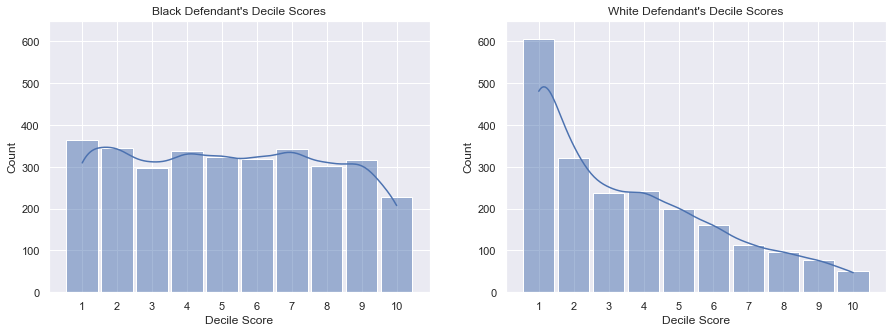

In [15]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.setp(axes, ylim=(0,650), xticks=np.arange(1,11), xlabel="Decile Score")

scores_black = df[df["race"]=="African-American"]["decile_score"]
scores_white = df[df["race"]=="Caucasian"]["decile_score"]

sns.histplot(
    x=scores_black,
    bins=10, 
    ax=axes[0], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[0].set_title("Black Defendant's Decile Scores")

sns.histplot(
    x=scores_white,
    bins=10, 
    ax=axes[1], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes[1].set_title("White Defendant's Decile Scores");


In [16]:
pd.crosstab(df["decile_score"], df["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [17]:
import statsmodels.formula.api as smf
from sklearn.preprocessing import OrdinalEncoder

In [18]:
#Create df for Logistic regression model 
df_log = df[['sex', 'age_cat', 'race', 'priors_count',
             'c_charge_degree', 'two_year_recid', 'score_text']].copy()

# Combine Medium and High Risk score into one category
df_log["score_text"] = df_log.score_text.apply(lambda x: 0 if x=="Low" else 1)#.astype('category')

# Rename columns according to ProPublica
df_log.columns = ['gender_factor','age_factor','race_factor', 'priors_count',
                  'crime_factor', 'two_year_recid', 'score_factor']

In [19]:
# Create list of labels for Ordinal Encoder so that the order is identical to ProPublica
gender_labels = ["Male","Female"]
age_labels = ['25 - 45', 'Greater than 45', 'Less than 25']
race_labels = ['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Native American', 'Other']
crime_labels = ['F', 'M']

#Instantiate Ordinal Encoder
ord_encoder = OrdinalEncoder(categories=[gender_labels, age_labels, race_labels, crime_labels])

In [20]:
# Create encoded df
df_log_enc = df_log.copy()

# Encode features (statsmodels requires numerical features)
df_log_enc[['gender_factor', 'age_factor', 'race_factor', 'crime_factor']] = ord_encoder.fit_transform(
    df_log[['gender_factor', 'age_factor', 'race_factor', 'crime_factor']]) 


In [21]:
# Fit model
formula = "score_factor ~ C(gender_factor) + C(age_factor) + C(race_factor)+ priors_count + C(crime_factor) + two_year_recid"
model = smf.logit(formula=formula, data=df_log_enc).fit()

Optimization terminated successfully.
         Current function value: 0.499708
         Iterations 6


In [22]:
# Create summary table with correct label names 
result = model.summary(xname=["Intercept",
                     "gender_factorFemale", 
                     "age_factorGreater than 45", 
                     "age_factorLess than 25",
                     "race_factorAfrican-American",
                     "race_factorAsian",
                     "race_factorHispanic",
                     "race_factorNative American",
                     "race_factorOther",
                     "crime_factorM",
                     "priors_count",
                     "two_year_recid"])

result

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           score_factor   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6160
Method:                           MLE   Df Model:                           11
Date:                Fri, 10 Dec 2021   Pseudo R-squ.:                  0.2729
Time:                        12:41:09   Log-Likelihood:                -3084.2
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.5255      0.079    -19.430      0.000      -1.679      -1.372
gender_factorFemale             0.2213      0.080      2.783      0.005       0.065       0.377
age_factorGreater than 45      -1.3556      0.099    -13.682      0.000      -1.550      -1.161
age_factorLess than 25          1.3084      0.076     17.232      0.000       1.160       1.457
race_factorAfrican-American     0.4772      0.069      6.881      0.000       0.341       0.613
race_factorAsian               -0.2544      0.478     -0.532      0.595      -1.192       0.683
race_factorHispanic            -0.4284      0.128     -3.344      0.001      -0.680      -0.177
race_factorNative American      1.3942      0.766      1.820      0.069      -0.107       2.896
race_factorOther               -0.8263      0.162     -5.098      0.000      -1.144      -0.509
crime_factorM                  -0.3112      0.067     -4.677      0.000      -0.442      -0.181
priors_count                    0.2689      0.011     24.221      0.000       0.247       0.291
two_year_recid                  0.6859      0.064     10.713      0.000       0.560       0.811
===============================================================================================
"""

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [23]:
intercept_coef = model.params["Intercept"] #Coefficient (log-odds) for Caucasian man between 25 and 45 receiving a high risk score
african_american_coef = model.params["C(race_factor)[T.1.0]"] #Coefficient (decrease in log-odds relative to white man) for African American man between 25 and 45 (see ord_encoder.categories_)

control = np.exp(intercept_coef) / (1+ np.exp(intercept_coef)) # Probability? of white man between 25-45 to receive a higher score
np.exp(african_american_coef) / (1- control + (control *np.exp(african_american_coef))) # ?


1.452837413382345

In [24]:
odds_white = np.exp(intercept_coef) # odds of white man between 25-45 to receive a higher score
odds_black = np.exp(intercept_coef+african_american_coef) # odds of african-american man between 25-45 to receive a higher score

odds_black/odds_white #odds ratio of black man compared to white man receiving a higher risk score

#same as above (odds_white cancel out)
np.exp(african_american_coef)


1.6115669697085946

In [25]:
(np.exp(-1.5255+0.4772)+np.exp(0.4772)) / (1+np.exp(-1.5255+0.4772)) #(odd black + odd white) / (1+odd black))

1.4528254070016209

Women are 19.4% more likely than men to get a higher score.

In [26]:
woman_coef = model.params["C(gender_factor)[T.1.0]"]

np.exp(woman_coef) / (1 - control + (control * np.exp(woman_coef)))

1.1947946538834509

In [27]:
odds_woman = np.exp(intercept_coef+woman_coef)

odds_woman/odds_white

1.2476561040261969

Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [28]:
young_coef = model.params["C(age_factor)[T.2.0]"]

np.exp(young_coef) / (1 - control + (control * np.exp(young_coef)))

2.496119530753955

### Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [29]:
csv_path_vio = os.path.join(root_dir, "data-ProPublica","compas-scores-two-years-violent.csv")

# Load data and transform date columsn to "datetime"
raw_data_vio = pd.read_csv(csv_path_vio)
#raw_data = pd.read_csv("../../data-ProPublica/compas-scores-two-years-violent.csv", parse_dates=["c_jail_in", "c_jail_out"])
raw_data_vio.shape


(4743, 54)

In [59]:
# Select columns of interest and store as new df
df_vio = raw_data_vio[["age", "c_charge_degree", "race", "age_cat", "v_score_text", "sex", "priors_count", 
          "days_b_screening_arrest", "v_decile_score", "is_recid", "two_year_recid"]]

# Filter rows as described by ProPublica
df_vio = df_vio[
        (df_vio["days_b_screening_arrest"]<=30) & 
        (df_vio["days_b_screening_arrest"]>=-30) &
        (df_vio["is_recid"]!=-1) & 
        (df_vio["c_charge_degree"]!="O") 
      ].dropna(subset=['v_score_text'])

df_vio.shape

(4020, 11)

In [31]:
df_vio.age_cat.value_counts()

25 - 45            2300
Greater than 45     954
Less than 25        766
Name: age_cat, dtype: int64

In [32]:
(df_vio.race.value_counts()).map('{:,.2f}'.format)

African-American    1,918.00
Caucasian           1,459.00
Hispanic              355.00
Other                 255.00
Asian                  26.00
Native American         7.00
Name: race, dtype: object

In [33]:
df_vio.v_score_text.value_counts()

Low       2913
Medium     828
High       279
Name: v_score_text, dtype: int64

In [34]:
no_recid_vio = np.sum(df_vio["two_year_recid"]==1)
print("Number of entries with two_year_recid:", no_recid_vio)
print("% of entries with two_year_recid", np.round(no_recid_vio/df_vio.shape[0]*100,2))

Number of entries with two_year_recid: 652
% of entries with two_year_recid 16.22


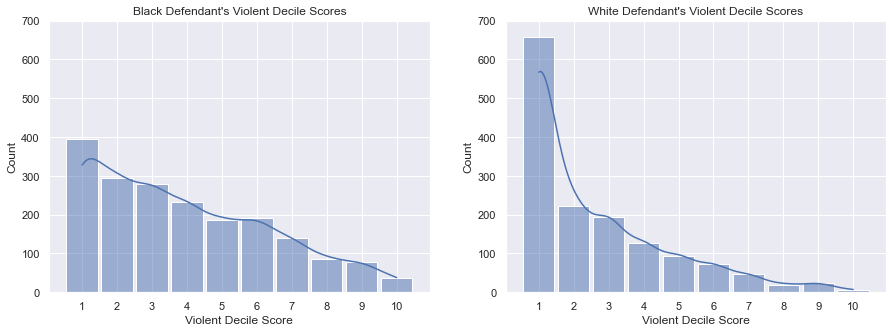

In [35]:
fig_vio, axes_vio = plt.subplots(1,2, figsize=(15,5))
plt.setp(axes_vio, ylim=(0,700), xticks=np.arange(1,11), xlabel="Violent Decile Score")

scores_black_vio = df_vio[df_vio["race"]=="African-American"]["v_decile_score"]
scores_white_vio = df_vio[df_vio["race"]=="Caucasian"]["v_decile_score"]

sns.histplot(
    x=scores_black_vio,
    bins=10, 
    ax=axes_vio[0], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes_vio[0].set_title("Black Defendant's Violent Decile Scores")

sns.histplot(
    x=scores_white_vio,
    bins=10, 
    ax=axes_vio[1], 
    kde=True,
    shrink=.9,
    discrete=True
            )
axes_vio[1].set_title("White Defendant's Violent Decile Scores");


In [36]:
#Create df for Logistic regression model 
df_log_vio = df_vio[['sex', 'age_cat', 'race', 'priors_count',
             'c_charge_degree', 'two_year_recid', 'v_score_text']].copy()

# Combine Medium and High Risk score into one category
df_log_vio["v_score_text"] = df_log_vio.v_score_text.apply(lambda x: 0 if x=="Low" else 1)#.astype('category')

# Rename columns according to ProPublica
df_log_vio.columns = ['gender_factor','age_factor','race_factor', 'priors_count',
                  'crime_factor', 'two_year_recid', 'score_factor']

In [37]:
# # Create list of labels for Ordinal Encoder so that the order is identical to ProPublica
# gender_labels = ["Male","Female"]
# age_labels = ['25 - 45', 'Greater than 45', 'Less than 25']
# race_labels = ['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Native American', 'Other']
# crime_labels = ['F', 'M']

#Instantiate Ordinal Encoder
ord_encoder_vio = OrdinalEncoder(categories=[gender_labels, age_labels, race_labels, crime_labels])

In [38]:
# Create encoded df
df_log_vio_enc = df_log_vio.copy()

# Encode features (statsmodels requires numerical features)
df_log_vio_enc[['gender_factor', 'age_factor', 'race_factor', 'crime_factor']] = ord_encoder_vio.fit_transform(
    df_log_vio[['gender_factor', 'age_factor', 'race_factor', 'crime_factor']]) 


In [39]:
# Fit model
formula_vio = "score_factor ~ C(gender_factor) + C(age_factor) + C(race_factor)+ priors_count + C(crime_factor) + two_year_recid"
model_vio = smf.logit(formula=formula_vio, data=df_log_vio_enc).fit()

Optimization terminated successfully.
         Current function value: 0.372983
         Iterations 7


In [40]:
# Create summary table with correct label names 
result_vio = model_vio.summary(xname=["Intercept",
                     "gender_factorFemale", 
                     "age_factorGreater than 45", 
                     "age_factorLess than 25",
                     "race_factorAfrican-American",
                     "race_factorAsian",
                     "race_factorHispanic",
                     "race_factorNative American",
                     "race_factorOther",
                     "crime_factorM",
                     "priors_count",
                     "two_year_recid"])

result_vio

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           score_factor   No. Observations:                 4020
Model:                          Logit   Df Residuals:                     4008
Method:                           MLE   Df Model:                           11
Date:                Fri, 10 Dec 2021   Pseudo R-squ.:                  0.3662
Time:                        12:41:11   Log-Likelihood:                -1499.4
converged:                       True   LL-Null:                       -2365.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -2.2427      0.113    -19.802      0.000      -2.465      -2.021
gender_factorFemale            -0.7289      0.127     -5.755      0.000      -0.977      -0.481
age_factorGreater than 45      -1.7421      0.184     -9.460      0.000      -2.103      -1.381
age_factorLess than 25          3.1459      0.115     27.259      0.000       2.920       3.372
race_factorAfrican-American     0.6589      0.108      6.093      0.000       0.447       0.871
race_factorAsian               -0.9852      0.705     -1.397      0.162      -2.368       0.397
race_factorHispanic            -0.0642      0.191     -0.335      0.737      -0.439       0.311
race_factorNative American      0.4479      1.035      0.433      0.665      -1.582       2.477
race_factorOther               -0.2054      0.225     -0.914      0.360      -0.646       0.235
crime_factorM                  -0.1637      0.098     -1.669      0.095      -0.356       0.029
priors_count                    0.1376      0.012     11.854      0.000       0.115       0.160
two_year_recid                  0.9345      0.115      8.107      0.000       0.709       1.160
===============================================================================================
"""

The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.

In [41]:
intercept_vio_coef = model_vio.params["Intercept"] #Log odds for Caucasian 
african_american_vio_coef = model_vio.params["C(race_factor)[T.1.0]"] #Log odds for African American (see ord_encoder.categories_)

control_vio = np.exp(intercept_vio_coef) / (1+ np.exp(intercept_vio_coef))
np.exp(african_american_vio_coef) / (1- control_vio + (control_vio *np.exp(african_american_vio_coef)))

1.77392741407041

Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

In [42]:
young_vio_coef = model_vio.params["C(age_factor)[T.2.0]"]

np.exp(young_vio_coef) / (1 - control_vio + (control_vio * np.exp(young_vio_coef)))

7.414231992873513

## Predictive Accuracy of COMPAS

>In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk,  we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their [validation study](http://cjb.sagepub.com/content/36/1/21.abstract).

>We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

In [50]:
csv_path_cox = os.path.join(root_dir, "data-ProPublica","cox-parsed.csv")

# Load data
raw_data_cox = pd.read_csv(csv_path_cox)

In [60]:
df_grp = raw_data_cox.copy()

# Filter rows as described by ProPublica
df_grp = df_grp[df_grp["end"]>df_grp["start"]].dropna(subset=['score_text']).drop_duplicates(["id"])
df_grp.shape

(10314, 52)

In [69]:
#Rename column names (no Ordinal Encoding yet)
df_grp = df_grp.rename(columns={"race": "race_factor", 'score_text': "score_factor"})

In [71]:
df_grp.score_factor.value_counts()

Low       5751
Medium    2611
High      1952
Name: score_factor, dtype: int64

In [74]:
(df_grp.race_factor.value_counts()).map('{:,.0f}'.format)

African-American    5,147
Caucasian           3,569
Hispanic              944
Other                 571
Asian                  51
Native American        32
Name: race_factor, dtype: object

## Directions of the Racial Bias

>The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.

In [77]:
from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable
from csv import DictReader

people = []
with open("../../data-ProPublica/cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))
recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))
rset = set(recid)
surv = [i for i in pop if i not in rset]

In [78]:
print("All defendants")
table(list(recid), list(surv))

All defendants
           	Low	High
Survived   	2681	1282	0.55
Recidivated	1216	2035	0.45
Total: 7214.00
False positive rate: 32.35
False negative rate: 37.40
Specificity: 0.68
Sensitivity: 0.63
Prevalence: 0.45
PPV: 0.61
NPV: 0.69
LR+: 1.94
LR-: 0.55


In [79]:
print("Total pop: %i" % (2681 + 1282 + 1216 + 2035))

Total pop: 7214


In [80]:
import statistics
print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, pop)),
                                                statistics.stdev(map(lambda i: i.lifetime, pop))))
print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, pop))))

Average followup time 622.87 (sd 392.19)
Median followup time 766


Overall, the false positive rate is 32.35%.

In [81]:
print("Black defendants")
is_afam = is_race("African-American")
table(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

Black defendants
           	Low	High
Survived   	990	805	0.49
Recidivated	532	1369	0.51
Total: 3696.00
False positive rate: 44.85
False negative rate: 27.99
Specificity: 0.55
Sensitivity: 0.72
Prevalence: 0.51
PPV: 0.63
NPV: 0.65
LR+: 1.61
LR-: 0.51


That number is higher for African Americans at 44.85%.

In [83]:
print("White defendants")
is_white = is_race("Caucasian")
table(list(filter(is_white, recid)), list(filter(is_white, surv)))

White defendants
           	Low	High
Survived   	1139	349	0.61
Recidivated	461	505	0.39
Total: 2454.00
False positive rate: 23.45
False negative rate: 47.72
Specificity: 0.77
Sensitivity: 0.52
Prevalence: 0.39
PPV: 0.59
NPV: 0.71
LR+: 2.23
LR-: 0.62


And lower for whites at 23.45%.

In [84]:
44.85 / 23.45

1.9125799573560769

Which means under COMPAS black defendants are 91% more likely to get a higher score and not go on to commit more crimes than white defendants after two year.

COMPAS scores misclassify white reoffenders as low risk at 70.4% more often than black reoffenders.

In [85]:
47.72 / 27.99

1.7048946052161487

In [86]:
hightable(list(filter(is_white, recid)), list(filter(is_white, surv)))

           	Low	High
Survived   	1407	81	0.61
Recidivated	771	195	0.39
Total: 2454.00
False positive rate: 5.44
False negative rate: 79.81
Specificity: 0.95
Sensitivity: 0.20
Prevalence: 0.39
PPV: 0.71
NPV: 0.65
LR+: 3.71
LR-: 0.84


In [87]:
hightable(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

           	Low	High
Survived   	1511	284	0.49
Recidivated	1160	741	0.51
Total: 3696.00
False positive rate: 15.82
False negative rate: 61.02
Specificity: 0.84
Sensitivity: 0.39
Prevalence: 0.51
PPV: 0.72
NPV: 0.57
LR+: 2.46
LR-: 0.72


## Risk of Violent Recidivism

>Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.

In [89]:
vpeople = []
with open("../../data-ProPublica/cox-violent-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

vpop = list(filter(lambda i: ((i.violent_recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.vscore_valid, vpeople))))
vrecid = list(filter(lambda i: i.violent_recidivist == True and i.lifetime <= 730, vpeople))
vrset = set(vrecid)
vsurv = [i for i in vpop if i not in vrset]

In [90]:
print("All defendants")
vtable(list(vrecid), list(vsurv))

All defendants
           	Low	High
Survived   	4121	1597	0.89
Recidivated	347	389	0.11
Total: 6454.00
False positive rate: 27.93
False negative rate: 47.15
Specificity: 0.72
Sensitivity: 0.53
Prevalence: 0.11
PPV: 0.20
NPV: 0.92
LR+: 1.89
LR-: 0.65


Even more so for Black defendants.

In [91]:
print("Black defendants")
is_afam = is_race("African-American")
vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

Black defendants
           	Low	High
Survived   	1692	1043	0.86
Recidivated	170	273	0.14
Total: 3178.00
False positive rate: 38.14
False negative rate: 38.37
Specificity: 0.62
Sensitivity: 0.62
Prevalence: 0.14
PPV: 0.21
NPV: 0.91
LR+: 1.62
LR-: 0.62


In [92]:
print("White defendants")
is_white = is_race("Caucasian")
vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))

White defendants
           	Low	High
Survived   	1679	380	0.91
Recidivated	129	77	0.09
Total: 2265.00
False positive rate: 18.46
False negative rate: 62.62
Specificity: 0.82
Sensitivity: 0.37
Prevalence: 0.09
PPV: 0.17
NPV: 0.93
LR+: 2.03
LR-: 0.77


Black defendants are twice as likely to be false positives for a Higher violent score than white defendants.

In [93]:
38.14 / 18.46

2.066088840736728

White defendants are 63% more likely to get a lower score and commit another crime than Black defendants.

In [95]:
62.62 / 38.37

1.63200416992442

## Gender differences in Compas scores

>In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.